Estimated laser threshold current: 48.08 mA
Below-threshold line:  P ~ 0.0026 * I + -0.0310
Above-threshold line:  P ~ 0.6349 * I + -30.4324
Knife-edge fit parameters:
P0     = 7.645 +/- 0.038 mW
x0     = 2.729 +/- 0.004 mm  (beam centre)
sigma  = 0.365 +/- 0.005 mm
Implied 1/e^2 beam radius w ~ 0.729 +/- 0.010 mm


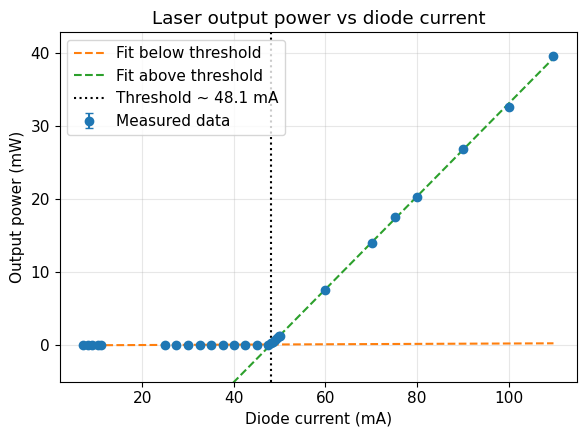

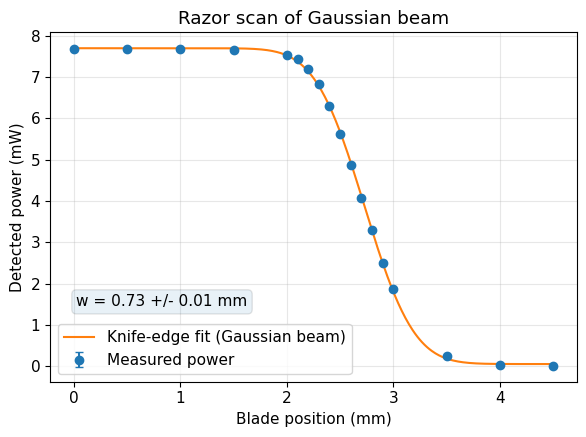

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import erf

# -------------------------------------------------------------
# 1. Saturated absorption: find threshold and fit lines
# -------------------------------------------------------------

# Load saturated-absorption data: columns must be 'current_mA', 'power_mW', 'err_mW'
sat = pd.read_csv("satabsorp.csv")

# Sort by current just in case
sat = sat.sort_values("current_mA").reset_index(drop=True)
x = sat["current_mA"].values
y = sat["power_mW"].values
y_err = sat["err_mW"].values


def find_threshold_piecewise_linear(x, y, min_points=4):
    """
    Fit two straight lines with a single breakpoint.
    Returns:
        idx_break   index of first point in the 'high' region
        (p_low, p_high)  line parameters [m, b] for low and high regions
        I_thr       intersection current in mA
    """
    n = len(x)
    best_sse = None
    best_idx = None
    best_params = None

    for i in range(min_points, n - min_points):
        xl, yl = x[:i], y[:i]
        xr, yr = x[i:], y[i:]

        # Linear fits: y = m x + b
        p_low = np.polyfit(xl, yl, 1)
        p_high = np.polyfit(xr, yr, 1)

        sse_low = np.sum((np.polyval(p_low, xl) - yl) ** 2)
        sse_high = np.sum((np.polyval(p_high, xr) - yr) ** 2)
        sse_total = sse_low + sse_high

        if best_sse is None or sse_total < best_sse:
            best_sse = sse_total
            best_idx = i
            best_params = (p_low, p_high)

    p_low, p_high = best_params
    m1, b1 = p_low
    m2, b2 = p_high

    # Intersection current (threshold)
    I_thr = (b1 - b2) / (m2 - m1)

    return best_idx, (p_low, p_high), I_thr


idx_break, (p_low, p_high), I_thr = find_threshold_piecewise_linear(x, y)

print(f"Estimated laser threshold current: {I_thr:.2f} mA")
print(f"Below-threshold line:  P ~ {p_low[0]:.4f} * I + {p_low[1]:.4f}")
print(f"Above-threshold line:  P ~ {p_high[0]:.4f} * I + {p_high[1]:.4f}")

# Prepare lines to plot
x_fit = np.linspace(x.min(), x.max(), 400)
y_low_fit = np.polyval(p_low, x_fit)
y_high_fit = np.polyval(p_high, x_fit)

# -------------------------------------------------------------
# 2. Beamwidth from razor scan: fit Gaussian via knife-edge model
# -------------------------------------------------------------

# Load beamwidth data: columns must be 'position_mm', 'signal_mW', 'err_mW'
beam = pd.read_csv("beamwidth.csv")
beam = beam.sort_values("position_mm").reset_index(drop=True)
xb = beam["position_mm"].values
yb = beam["signal_mW"].values
yb_err = beam["err_mW"].values


def knife_edge_model(x, P0, x0, sigma, offset):
    """
    Knife-edge power vs blade position for a Gaussian beam:
        P(x) = offset + 0.5 * P0 * [1 - erf((x - x0) / (sqrt(2) * sigma))]

    Here:
        P0     ~ total beam power
        x0     ~ beam centre (mm)
        sigma  ~ Gaussian sigma of the *intensity* profile (mm)
        offset ~ residual background / offset (mW)
    """
    return offset + 0.5 * P0 * (1 - erf((x - x0) / (np.sqrt(2) * sigma)))


# Initial guesses for the fit
P0_guess = yb.max() - yb.min()
x0_guess = xb[np.argmin(np.abs(yb - (yb.max() + yb.min()) / 2))]
sigma_guess = (xb.max() - xb.min()) / 4.0
offset_guess = yb.min()

p0 = [P0_guess, x0_guess, sigma_guess, offset_guess]

popt, pcov = curve_fit(knife_edge_model, xb, yb, p0=p0)

P0_fit, x0_fit, sigma_fit, offset_fit = popt
perr = np.sqrt(np.diag(pcov))

print("Knife-edge fit parameters:")
print(f"P0     = {P0_fit:.3f} +/- {perr[0]:.3f} mW")
print(f"x0     = {x0_fit:.3f} +/- {perr[1]:.3f} mm  (beam centre)")
print(f"sigma  = {sigma_fit:.3f} +/- {perr[2]:.3f} mm")

# For a Gaussian intensity profile I(x) = I0 * exp[-2 (x / w)^2],
# one can show that sigma = w / 2, so w = 2 sigma.
w_fit = 2 * sigma_fit
w_err = 2 * perr[2]
print(f"Implied 1/e^2 beam radius w ~ {w_fit:.3f} +/- {w_err:.3f} mm")

# Smooth curve for plotting
xb_fit = np.linspace(xb.min(), xb.max(), 400)
yb_fit = knife_edge_model(xb_fit, *popt)

# -------------------------------------------------------------
# 3. Plotting: graphs suitable for a lab report
# -------------------------------------------------------------

plt.rcParams.update({
    "figure.figsize": (6.0, 4.5),
    "font.size": 11
})

# Figure 1: Laser power vs current with threshold fit
fig1, ax1 = plt.subplots()

ax1.errorbar(x, y, yerr=y_err, fmt="o", color="C0", label="Measured data", zorder=3, capsize=3)
ax1.plot(x_fit, y_low_fit, "C1--", label="Fit below threshold")
ax1.plot(x_fit, y_high_fit, "C2--", label="Fit above threshold")
ax1.axvline(I_thr, color="k", linestyle=":", label=f"Threshold ~ {I_thr:.1f} mA")

ax1.set_xlabel("Diode current (mA)")
ax1.set_ylabel("Output power (mW)")
ax1.set_ylim(bottom=-5)
ax1.set_title("Laser output power vs diode current")
ax1.grid(True, alpha=0.3)
ax1.legend()

fig1.tight_layout()

# Figure 2: Razor scan with knife-edge (Gaussian) fit
fig2, ax2 = plt.subplots()

ax2.errorbar(xb, yb, yerr=yb_err, fmt="o", color="C0", label="Measured power", zorder=3, capsize=3)
ax2.plot(xb_fit, yb_fit, "C1-", label="Knife-edge fit (Gaussian beam)")

annotation = f"w = {w_fit:.2f} +/- {w_err:.2f} mm"
ax2.text(0.05, 0.25, annotation, transform=ax2.transAxes,
         ha="left", va="top", bbox=dict(boxstyle="round", alpha=0.1))

ax2.set_xlabel("Blade position (mm)")
ax2.set_ylabel("Detected power (mW)")
ax2.set_title("Razor scan of Gaussian beam")
ax2.grid(True, alpha=0.3)
ax2.legend()

fig2.tight_layout()

plt.show()
